# Integration of SVM and MVO 

This notebook performs a comparison of the integrated MVO-SVM min variance portfolios obtained via the exact MIP solve vs the ADM method


In [1]:
import gurobipy as gp
from gurobipy import GRB
pth = ''
import sys
import math
import time
sys.path.append(pth + 'SVM MVO/PYFILES/')
from python.packages import *
from python.svm_mvo import *
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'DATA/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'DATA/PRICES.pkl')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-09


FileNotFoundError: [Errno 2] No such file or directory: 'DATA/Forecasts.pkl'

In [3]:
mth = rets.index[8]
mth

Timestamp('2001-03-01 00:00:00')

In [4]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)
#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"Momentum"] # Y matrix in formulation 
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
Y_ = Y_.iloc[:,:]
#Y_ = Y_[['ROC1', 'INV1', 'PRO1'	, 'GRW1', 'LEV1', 'LIQ1']]
cols = ['LEV1', 'GRW1', 'ROC1', 'PRO1', 'Momentum']
Y_ = Y_[cols]
#Y_['momentum'] = mean
AssetLim = math.floor(N*0.8)

ret_constr = -1
soft_margin = 2000

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

### Mean Variance and SVM Joint Using Alternating Directions Method Class Definition

In [5]:
MVO_ = MVO(tics, mean, cov, ret_constr, Y_, AssetLim)
SVM_ = SVM(tics, Y_ , soft_margin)
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 10, ParamLim = 15)
SVM_MVO_Fast.MVO_.model.params.MIPGap = 0.05 
SVM_MVO_Fast.SVM_.model.params.timelimit = 60
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
start = time.time()
SVM_MVO_Fast.initialize_soln()
ws , xs, zs , xi_mvo, xi_svm, dt, objs_svm, objs_mvo = SVM_MVO_Fast.solve_ADM()
end = time.time()
print("Solution time", end - start)

Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 60
Solution time 30.37742805480957


### ADM method with individual updates on the penalty parameters

In [6]:
MVO_2 = MVO(tics, mean, cov, ret_constr, Y_, AssetLim)
SVM_2 = SVM(tics, Y_ , soft_margin*np.ones_like(mean))

SVM_MVO_Fast_v2 = SVM_MVO_ADM_v2(MVO_2, SVM_2, IterLim = 10, ParamLim = 15)
SVM_MVO_Fast_v2.MVO_.model.params.MIPGap = 0.05 
SVM_MVO_Fast_v2.SVM_.model.params.timelimit = 60
SVM_MVO_Fast_v2.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast_v2.SVM_.model.params.OutputFlag = 0
start = time.time()
SVM_MVO_Fast_v2.initialize_soln()
ws_2, xs_2, zs_2 , xi_mvo_2, xi_svm_2, dt_2, objs_svm_2, objs_mvo_2 = SVM_MVO_Fast_v2.solve_ADM()
end = time.time()
print("Solution time", end - start)

Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 60
Stalling at Infeasible Point
SVM  0.07263871109545679
MVO  0.07262819945961772
Stalling at Infeasible Point
SVM  0.0008328282564668694
MVO  0.0008328168377565092
ADM terminated with average value of C =  247.69005408653845
Solution time 20.584164142608643


array([[2.03181848e-04, 8.62742653e-13, 3.59424981e-05, 1.32698337e-04,
        5.93762031e-15],
       [3.05163416e-03, 1.54556339e-04, 1.57190448e-05, 2.87224437e-03,
        1.32410330e-09],
       [2.81135824e-03, 2.08427251e-04, 6.51695063e-05, 2.89068410e-03,
        2.32843731e-09],
       [2.31933016e-03, 2.83051061e-04, 4.36461840e-04, 2.18449921e-03,
        2.36000621e-09],
       [1.59374289e-03, 3.25093374e-04, 6.73757859e-04, 1.64189972e-03,
        2.02707304e-08],
       [1.59374289e-03, 3.25093374e-04, 6.73757859e-04, 1.64189972e-03,
        2.02707304e-08],
       [1.59374289e-03, 3.25093374e-04, 6.73757859e-04, 1.64189972e-03,
        2.02707304e-08],
       [1.59374289e-03, 3.25093374e-04, 6.73757859e-04, 1.64189972e-03,
        2.02707304e-08],
       [1.59374289e-03, 3.25093374e-04, 6.73757859e-04, 1.64189972e-03,
        2.02707304e-08],
       [1.59374289e-03, 3.25093374e-04, 6.73757859e-04, 1.64189972e-03,
        2.02707304e-08],
       [1.59374289e-03, 3.2509

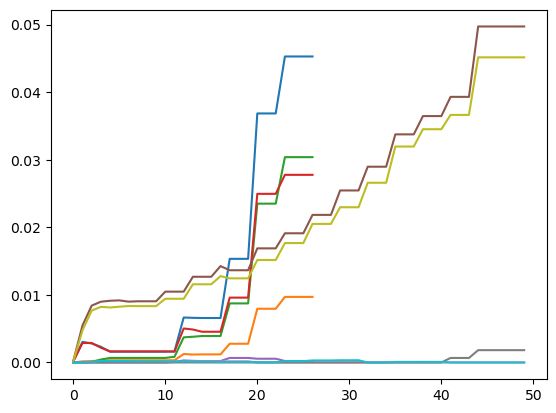

In [7]:
#plt.plot(ws[:,1])
np.abs(SVM_MVO_Fast_v2.SVM_.w.x).sum()*10**(-3)
plt.plot(ws_2)
plt.plot(ws)
ws_2

##Exact MIP Solution 

In [8]:
#SVM with slack 
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim, \
                      svm_choice = (True, True), print_var_frntr = False, indicator = False)
# starts = [SVM_MVO_Fast.x.x, SVM_MVO_Fast.z.x, SVM_MVO_Fast.w.x, SVM_MVO_Fast.b.x]
# SVM_MVO_Slck.set_model(start = starts)
# # SVM_MVO_Slck.model.params.Presolve = 2
# # SVM_MVO_Slck.model.Params.ImpliedCuts = 2
# SVM_MVO_Slck.optimize()

TypeError: 'float' object is not iterable

In [ ]:
SVM_MVO_Slck.model.reset(clearall = 1)
SVM_MVO_Slck.set_model()
SVM_MVO_Slck.optimize()

Discarded solution information including additional information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 861 rows, 1150 columns and 6006 nonzeros
Model fingerprint: 0x62fa3da6
Model has 41046 quadratic objective terms
Variable types: 864 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+02]
  Objective range  [7e+00, 7e+00]
  QObjective range [7e-08, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]
Found heuristic solution: objective 4.000000e+12
Presolve removed 1 rows and 286 columns
Presolve time: 0.02s
Presolved: 860 rows, 864 columns, 5720 nonzeros
Presolved model has 41046 quadratic objective terms
Variable types: 578 continuous, 286 integer (286 binary)

Root relaxation: objective 5.424763e-04, 673 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl

13.797144889831543

In [ ]:
#warm starts 
SVM_MVO_Slck.model.reset(clearall = 1)
starts = [SVM_MVO_Fast.x.x, SVM_MVO_Fast.z.x, SVM_MVO_Fast.w.x, SVM_MVO_Fast.b.x]
SVM_MVO_Slck.set_model(start = starts)
SVM_MVO_Slck.set_model()
SVM_MVO_Slck.optimize()

Discarded solution information including additional information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 1721 rows, 1150 columns and 11726 nonzeros
Model fingerprint: 0x7f4ce0fa
Model has 41046 quadratic objective terms
Variable types: 864 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+02]
  Objective range  [7e+00, 7e+00]
  QObjective range [7e-08, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]

User MIP start produced solution with objective 0.00295231 (0.05s)
Loaded user MIP start with objective 0.00295231

Presolve removed 861 rows and 286 columns
Presolve time: 0.02s
Presolved: 860 rows, 864 columns, 5720 nonzeros
Presolved model has 41046 quadratic objective terms
Variable types: 578 continuous, 286 integer (286 binary)

Root relaxation: objective 5.424763e-04, 673 iterations, 0.02 seconds

    No

57.879053354263306

## Comparison between exact and ADM method

In [ ]:
return_premium = -1 #(Min variance portfolio)
T = 20#int(len(rets.index)/10)

In [ ]:
import time
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-8:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 60s
    if time.time() - model._time > 60:
        model.terminate()

def evaluate_model(rets, forecasts, wrds_svm, return_premium, model_instance, T, N, cols):
  # lr = 0.1 #learning rate for the SVM support vector
  portfolio_weights = np.zeros([T,N])
  xi = np.zeros([T,N])
  z = np.zeros([T,N])

  oot_returns = np.zeros(T)
  risks = np.zeros(T)
  svm_margins = np.zeros(T)
  svm_penalties = np.zeros(T)

  market = np.zeros(T)
  M = len(cols)
  wis = np.zeros([T,M])
  bias = np.zeros(T)
  
  times = np.zeros(T)
  i = 0 #index for dates
  w_mabs = 0 #initialize
  # soln_mods = {}

  for prd in rets.index.to_list()[:T]:
    ret_ = rets.loc[prd][:N]
    cov_, mean_ = forecasts[prd]
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    return_premium_temp = return_premium 
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    #restrict the wharton research data to the columns of interest
    #modifying WRDS dataset here if required
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
    Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
    if return_premium == -1:
      ret_constr = -1
    else:
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium)
    model_instance.tics = tics
    model_instance.ret_constr = ret_constr
    model_instance.mean_ret = mean
    model_instance.cov = cov
    model_instance.exogenous = Y_

    # if i > 0: #not the first trade gets a constraint on turnover
    #   x_prev = model_instance.x.X

    # if model_instance.svm_constr:
    #   w_mabs = (i/(i+1))*w_mabs + (1/(i+1))*np.abs(model_instance.w.x).mean()
    #   w_prev = model_instance.w.x
    model_instance.model.reset(clearall = 1)
    model_instance.set_model()

    # if i > 0: #not the first trade gets a constraint on turnover
    #   model_instance.define_turnover(x_prev, np.ones_like(x_prev), Limit, 1)

    # if model_instance.svm_constr:
    #   u = model_instance.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
    #   wcon1 = model_instance.model.addConstr(model_instance.w <= w_prev + lr*w_mabs*u + model_instance.epsilon, 'iter constraint 1')
    #   wcon2 = model_instance.model.addConstr(model_instance.w >= w_prev - lr*w_mabs*u - model_instance.epsilon, 'iter constraint 2')

    model_instance.model.Params.LogToConsole = 0
    model_instance.model.setParam('TimeLimit', 1000)
    start = time.time()
    model_instance.optimize()
    end = time.time()
    dt = end - start 
    print(dt)
    # k = 1
    # while model_instance.model.status == 4:
    #   #if the model is infeasible the decrease the return constraint
    #   #we do not have enough turnover the modify the portfolio to achive the 
    #   #return target... not a great place to be
    #   return_premium_temp = return_premium - 0.05*k
    #   ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
    #   model_instance.ret_constr = ret_constr
    #   model_instance.ret_target[0].rhs = ret_constr
    #   model_instance.optimize(cbb = cb)
    #   k = k+1
      #relax the return target bc the turnover constraint isnt allowing it to solve


    # if model_instance.model.IsMIP:
    #   soln_mods[prd] = [model_instance.model.MIPGap, return_premium_temp]
    # else:
    #   soln_mods[prd] = return_premium_temp
    
    oot_returns[i] = model_instance.evaluate(ret_)
    market[i] = ret_.mean()
    risks[i] = model_instance.portfolio_risk.getValue()[0]
    svm_margins[i] = model_instance.svm_margin.getValue()[0]
    svm_penalties[i] = model_instance.soft_penalty.getValue()[0]
    portfolio_weights[i, :] = model_instance.x.x
    xi[i,:] = model_instance.xi.x
    z[i,:] = model_instance.z.x
    times[i] = dt
    
  
    if model_instance.svm_constr:
      wis[i,:] = model_instance.w.x
      bias[i] = model_instance.b.x
    if i + 1 >= T:
      break
    if i%12 == 0:
      print("_"*25)
      print("Iteration ", i)
      print("Percent Complete ", i/T)
      objective_information = pd.DataFrame([oot_returns, market, risks, svm_margins, svm_penalties,times]
                                        , columns = rets.index[:T],
                                        index = ["Return", "Market", "Risk", 
                                                    "Margin", "Infeasibility", "Run-Time"])
      #eligible_weights = pd.DataFrame()
      portfolio_weights_pd = pd.DataFrame(portfolio_weights, index = rets.index[:T], columns = model_instance.tics)
      xi_pd = pd.DataFrame(xi, index = rets.index[:T], columns = model_instance.tics)
      z_pd = pd.DataFrame(z, index = rets.index[:T], columns = model_instance.tics)

      svm_weights = pd.DataFrame(wis, index = rets.index[:T], columns = cols)
      svm_weights['bias'] = bias
      
      svm_results = (portfolio_weights_pd, objective_information.T, svm_weights, z_pd, xi_pd)
      with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_exact_mvp_lrg_v4.pkl", 'wb') as fp:
        pkl.dump(svm_results, fp);
    i = i+1
  objective_information = pd.DataFrame([oot_returns, market, risks, svm_margins, svm_penalties,times]
                                    , columns = rets.index[:T],
                                    index = ["Return", "Market", "Risk", 
                                                "Margin", "Infeasibility", "Run-Time"])
  #eligible_weights = pd.DataFrame()
  portfolio_weights_pd = pd.DataFrame(portfolio_weights, index = rets.index[:T], columns = model_instance.tics)
  xi_pd = pd.DataFrame(xi, index = rets.index[:T], columns = model_instance.tics)
  z_pd = pd.DataFrame(z, index = rets.index[:T], columns = model_instance.tics)

  svm_weights = pd.DataFrame(wis, index = rets.index[:T], columns = cols)
  svm_weights['bias'] = bias
  
  svm_results = (portfolio_weights_pd, objective_information.T, svm_weights, z_pd, xi_pd)
  with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_exact_mvp_lrg_v4.pkl", 'wb') as fp:
    pkl.dump(svm_results, fp);
  return (portfolio_weights_pd, objective_information.T, svm_weights, z_pd, xi_pd)


In [ ]:
evaluate_model(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Slck, T, N, cols)

Discarded solution information including additional information
1000.104719877243
_________________________
Iteration  0
Percent Complete  0.0
205.03198218345642
1000.1003212928772
1000.1182105541229
1000.0968430042267
447.86290097236633
362.0027115345001
1000.1002111434937
668.1712746620178
811.5645759105682
209.39254593849182
757.0424346923828
1000.0985534191132
_________________________
Iteration  12
Percent Complete  0.6
409.7211842536926
1000.1037745475769
420.2129502296448
900.5610933303833
437.2213776111603
653.8060443401337
373.18468022346497


(                AAPL  ABC      ABMD  ...       XRX       YUM      ZBRA
 StartMonth                           ...                              
 2000-07-01  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.027266
 2000-08-01  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.015239
 2000-09-01  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.007967
 2000-10-01  0.000000  0.0  0.013493  ...  0.000000  0.000000  0.003240
 2000-11-01  0.004244  0.0  0.000000  ...  0.000000  0.000000  0.000000
 2000-12-01  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.000196
 2001-01-01  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.000000
 2001-02-01  0.003171  0.0  0.000000  ...  0.002136  0.000000  0.000529
 2001-03-01  0.005697  0.0  0.000000  ...  0.000000  0.000000  0.005615
 2001-04-01  0.004988  0.0  0.000000  ...  0.007151  0.000000  0.026164
 2001-05-01  0.002625  0.0  0.000000  ...  0.000000  0.000000  0.004816
 2001-06-01  0.000000  0.0  0.000000  ...  0.000000  0.000000  0

In [ ]:
def evaluate_adm_warm(rets, forecasts, wrds_svm, return_premium, models, T, 
                 N, cols, link):
  '''this function tests the ADM penalty method as a warm start and then feeds 
  it to the exact solver. This should result in faster exact solves
  models: tuple of model objects of length two where the first onject represents the 
  ADM object and the second object represents the exact MIP solver'''
  #models is tuple of the MIP model and the ADM object 
  model_adm, model_exact = models
  # lr = 0.1 #learning rate for the SVM support vector
  portfolio_weights = np.zeros([T,N])
  xi = np.zeros([T,N])
  z = np.zeros([T,N])
  oot_returns = np.zeros(T)
  risks = np.zeros(T)
  svm_margins = np.zeros(T)
  svm_penalties = np.zeros(T)
  
  market = np.zeros(T)
  M = len(cols)
  wis = np.zeros([T,M])
  bias = np.zeros(T)
  
  times = np.zeros(T)
  i = 0 #index for dates
  w_mabs = 0 #initialize
  # soln_mods = {}

  for prd in rets.index.to_list()[:T]:
    ret_ = rets.loc[prd][:N]
    cov_, mean_ = forecasts[prd]
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    return_premium_temp = return_premium 
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    #restrict the wharton research data to the columns of interest
    #modifying WRDS dataset here if required
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
    Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
    if return_premium == -1:
      ret_constr = -1
    else:
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium)
   
    model_adm.MVO_.tics = tics
    model_adm.SVM_.tics = tics
    model_adm.MVO_.ret_constr = ret_constr
    model_adm.MVO_.mean_ret = mean
    model_adm.MVO_.cov = cov
    model_adm.MVO_.exogenous = Y_
    model_adm.SVM_.exogenous = Y_
    model_adm.SVM_.model.reset(clearall = 1)
    model_adm.MVO_.model.reset(clearall = 1)

  
    model_exact.tics = tics
    model_exact.ret_constr = ret_constr
    model_exact.mean_ret = mean
    model_exact.cov = cov
    model_exact.exogenous = Y_

    model_exact.model.reset(clearall = 1)
    model_exact.set_model()

    # if i > 0: #not the first trade gets a constraint on turnover
    #   model_instance.define_turnover(x_prev, np.ones_like(x_prev), Limit, 1)

    # if model_instance.svm_constr:
    #   u = model_instance.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
    #   wcon1 = model_instance.model.addConstr(model_instance.w <= w_prev + lr*w_mabs*u + model_instance.epsilon, 'iter constraint 1')
    #   wcon2 = model_instance.model.addConstr(model_instance.w >= w_prev - lr*w_mabs*u - model_instance.epsilon, 'iter constraint 2')

    model_exact.model.Params.LogToConsole = 0
    model_exact.model.setParam('TimeLimit', 1000)

    model_adm.SVM_.model.reset(clearall = 1)
    model_adm.MVO_.model.reset(clearall = 1)

    start = time.time()
    model_adm.initialize_soln()
    # else:
    #   start = time.time()

    # if i > 0: #not the first trade gets a constraint on turnover
    #   model_instance.define_turnover(x_prev, np.ones_like(x_prev), Limit, 1)

    # if model_instance.svm_constr:
    #   u = model_instance.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
    #   wcon1 = model_instance.model.addConstr(model_instance.w <= w_prev + lr*w_mabs*u + model_instance.epsilon, 'iter constraint 1')
    #   wcon2 = model_instance.model.addConstr(model_instance.w >= w_prev - lr*w_mabs*u - model_instance.epsilon, 'iter constraint 2')

    model_adm.silence_output()
    model_adm.solve_ADM(store_data=False)
    starts = [model_adm.x.x, model_adm.z.x, model_adm.w.x, model_adm.b.x]
    model_exact.set_model(start = starts)
    model_exact.optimize()
    end = time.time()
    dt = end-start
    print(dt)
    # k = 1
    # while model_instance.model.status == 4:
    #   #if the model is infeasible the decrease the return constraint
    #   #we do not have enough turnover the modify the portfolio to achive the 
    #   #return target... not a great place to be
    #   return_premium_temp = return_premium - 0.05*k
    #   ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
    #   model_instance.ret_constr = ret_constr
    #   model_instance.ret_target[0].rhs = ret_constr
    #   model_instance.optimize(cbb = cb)
    #   k = k+1
      #relax the return target bc the turnover constraint isnt allowing it to solve

    # if model_instance.model.IsMIP:
    #   soln_mods[prd] = [model_instance.model.MIPGap, return_premium_temp]
    # else:
    #   soln_mods[prd] = return_premium_temp
    
    oot_returns[i] = model_exact.evaluate(ret_)
    market[i] = ret_.mean()
    portfolio_weights[i, :] = model_exact.x.x
    xi[i,:] = model_exact.xi.x
    z[i,:] = model_exact.z.x
    risks[i] = model_exact.portfolio_risk.getValue()[0]
    svm_margins[i] = model_exact.svm_margin.getValue()[0]
    svm_penalties[i] = model_exact.soft_penalty.getValue()[0]
    times[i] = dt
    wis[i,:] = model_exact.w.x
    bias[i] = model_exact.b.x
    
    if i + 1 >= T:
      break
      
    if i%12 == 0:
      print("_"*25)
      print("Iteration ", i)
      print("Percent Complete ", i/T)  
      objective_information = pd.DataFrame([oot_returns, market, risks, svm_margins, svm_penalties,times]
                                       , columns = rets.index[:T],
                                       index = ["Return", "Market", "Risk", 
                                                  "Margin", "Infeasibility", "Run-Time"])
      #eligible_weights = pd.DataFrame()
      portfolio_weights_pd = pd.DataFrame(portfolio_weights, index = rets.index[:T], columns = model_exact.tics)
      xi_pd = pd.DataFrame(xi, index = rets.index[:T], columns = model_exact.tics)
      z_pd = pd.DataFrame(z, index = rets.index[:T], columns = model_exact.tics)

      svm_weights = pd.DataFrame(wis, index = rets.index[:T], columns = cols)
      svm_weights['bias'] = bias
      adm_results = (portfolio_weights, objective_information.T, svm_weights, z_pd, xi_pd)
      with open(link, 'wb') as fp:
        pkl.dump(adm_results, fp);
    i = i+1 
  objective_information = pd.DataFrame([oot_returns, market, risks, svm_margins, svm_penalties,times]
                                  , columns = rets.index[:T],
                                  index = ["Return", "Market", "Risk", 
                                              "Margin", "Infeasibility", "Run-Time"])
  #eligible_weights = pd.DataFrame()
  portfolio_weights_pd = pd.DataFrame(portfolio_weights, index = rets.index[:T], columns = model_exact.tics)
  xi_pd = pd.DataFrame(xi, index = rets.index[:T], columns = model_exact.tics)
  z_pd = pd.DataFrame(z, index = rets.index[:T], columns = model_exact.tics)

  svm_weights = pd.DataFrame(wis, index = rets.index[:T], columns = cols)
  svm_weights['bias'] = bias
  adm_results = (portfolio_weights, objective_information.T, svm_weights, z_pd, xi_pd)
  with open(link, 'wb') as fp:
    pkl.dump(adm_results, fp);
  return (portfolio_weights_pd, objective_information.T, svm_weights, z_pd, xi_pd)

In [ ]:
link = "gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_adm_exact_huge_v5.pkl"
models2 = ( SVM_MVO_Fast_v2, SVM_MVO_Slck)
evaluate_adm_warm(rets, forecasts, wrds_svm, return_premium, models2, T, 
                 N, cols, link)

link = "gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_adm_exact_huge_v4.pkl"
models = ( SVM_MVO_Fast, SVM_MVO_Slck)
evaluate_adm_warm(rets, forecasts, wrds_svm, return_premium, models, T, 
                 N, cols, link)


ADM terminated with average value of C =  207.92330228365384
1039.676097393036
_________________________
Iteration  0
Percent Complete  0.0
ADM terminated with average value of C =  19659.5458984375
1044.3411164283752
ADM terminated with average value of C =  1974.7032752403845
1046.9435770511627
ADM terminated with average value of C =  19659.5458984375
1034.286384344101
ADM terminated with average value of C =  1787.2314453125
1028.4971520900726
ADM terminated with average value of C =  19659.5458984375
471.93223428726196
ADM terminated with average value of C =  215567.60817307694
1024.720052242279
ADM terminated with average value of C =  162.4755859375
1025.2500939369202
ADM terminated with average value of C =  1787.2314453125
1033.4922494888306
ADM terminated with average value of C =  1787.2314453125
1015.4438586235046
ADM terminated with average value of C =  1849.7220552884614
269.80638670921326
ADM terminated with average value of C =  1787.2314453125
